In [1]:
import numpy as np
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as constants

import sys
import os
dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"

sys.path.append(dir_BinnedFit)
from gen_mocks import gen_mock_tfCube
from RotationCurveFit import RotationCurveFit, GaussFit_signle
from ChainTool import ChainTool

sys.path.append(dir_KLens)
from KLtool import plot_specs

In [2]:
###### set up parameters ######

line_species='Halpha'

pars = {}
pars['g1'] = 0.0
pars['g2'] = 0.0
pars['sini'] = 0.5

pars['redshift'] = 0.4

pars['aspect'] = 0.2
pars['r_hl_image'] = 0.5
pars['r_hl_spec'] = 0.5


pars['theta_int'] = 0. #np.pi/3.

pars['slitWidth'] = 0.12
pars['ngrid'] = 128

pars['norm'] = 0.0

pars['Resolution'] = 5000.
pars['expTime'] = 60.*30. #60.*30.
pars['pixScale'] = 0.1185
pars['nm_per_pixel'] = 0.033
pars['throughput'] = 0.29
pars['psfFWHM'] = 0.5

pars['area'] = 3.14 * (1000./2.)**2 

pars['vcirc'] = 200.

linelist = np.empty(5,dtype=[('species',np.str_,16),
                                  ('lambda',np.float),
                                  ('flux',np.float)])
linelist['species'] = ['OIIa','OIIb','OIIIa','OIIIb','Halpha']
linelist['lambda'] =  [372.7092,372.9875,496.0295,500.8240,656.461]

fiber_SDSS = np.pi * 1.5**2
refSDSSspec = 3.*1e-17 * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)

linelist['flux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]

pars['linelist'] = linelist



In [3]:
dataInfo = gen_mock_tfCube(pars, line_species, noise_mode=0)

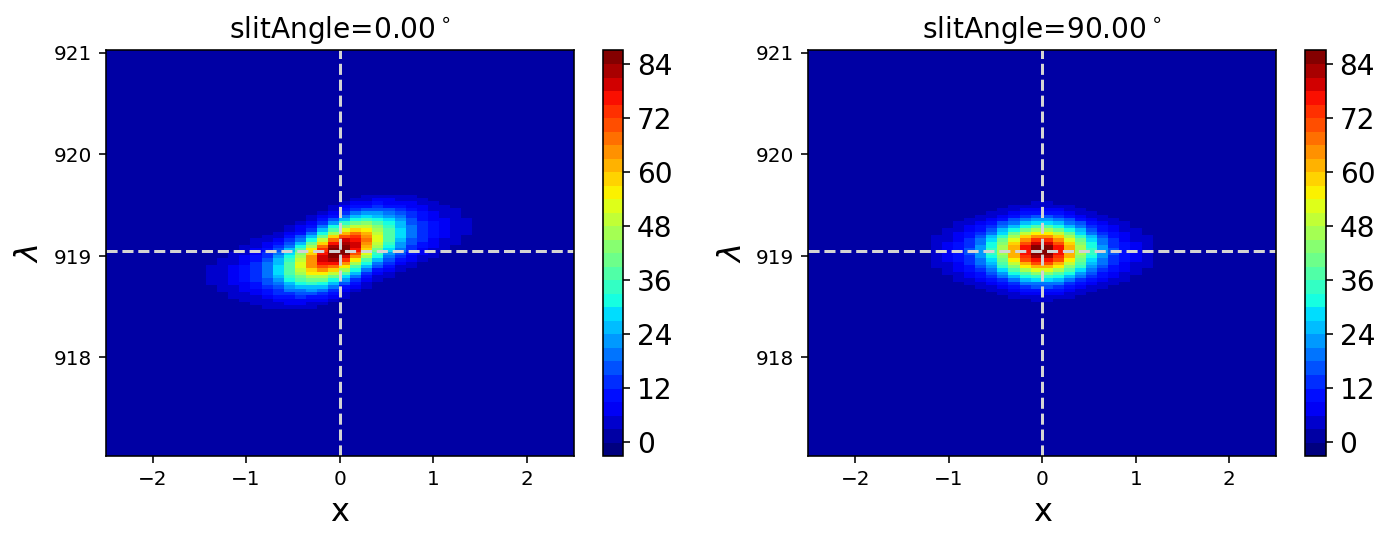

In [4]:
spec_arrs = [dataInfo['spec'][0].array, dataInfo['spec'][1].array]
plot_specs(spec_arrs, slitAngles=dataInfo['par_fid']['slitAngles'], 
           spaceGrid=dataInfo['spaceGrid'], lambdaGrid=dataInfo['lambdaGrid'], xlim=[-2.5, 2.5])

In [5]:
spec = dataInfo['spec']
lambda0 = dataInfo['lambda0']
par_fid = dataInfo['par_fid']

In [6]:
def get_velocityGrid(lambdaGrid, lambda_cen):
    zGrid = lambdaGrid/lambda_cen - 1.
    c_kms = 299792.458
    vGrid = zGrid*c_kms
    return vGrid

# Plot spectrum (velocity unit)

In [7]:
#GaussFit = GaussFit_signle(spec2D=spec[0], lambda0=lambda0)
GaussFit = GaussFit_signle(spec2D=spec[0], lambda0=lambda0, thresholdSNR=5e-6)


fitted_peakLambda, fitted_amp, fitted_sigma = GaussFit.gaussFit_spec2D()
model = GaussFit.model_spec2D(fitted_peakLambda,fitted_amp,fitted_sigma)

# get pixel edges
spaceGrid = GaussFit.spec2D.spaceGrid
lambdaGrid = GaussFit.spec2D.lambdaGrid
lambda_min = np.min(lambdaGrid)  ; lambda_MAX = np.max(lambdaGrid)
x_min = np.min(spaceGrid)        ; x_MAX = np.max(spaceGrid)

lambda_cen = lambda0*(1.+par_fid['redshift'])

vGrid = get_velocityGrid(lambdaGrid=lambdaGrid, lambda_cen=lambda_cen)

time cost in gaussFit_spec2D: 0.059123992919921875 (secs)


In [8]:
fitted_peakVelocity = get_velocityGrid(lambdaGrid=fitted_peakLambda, lambda_cen=lambda_cen)

In [9]:
fitted_lambda_up = fitted_peakLambda+fitted_sigma
fitted_lambda_lo = fitted_peakLambda-fitted_sigma

fitted_velocity_lo = get_velocityGrid(lambdaGrid=fitted_lambda_up, lambda_cen=lambda_cen) - fitted_peakVelocity
fitted_velocity_up = fitted_peakVelocity - get_velocityGrid(lambdaGrid=fitted_lambda_lo, lambda_cen=lambda_cen) 

fitted_velocity_error = np.vstack((fitted_velocity_lo, fitted_velocity_up))
fitted_velocity_error.shape

(2, 52)

Text(0, 0.5, 'velocity')

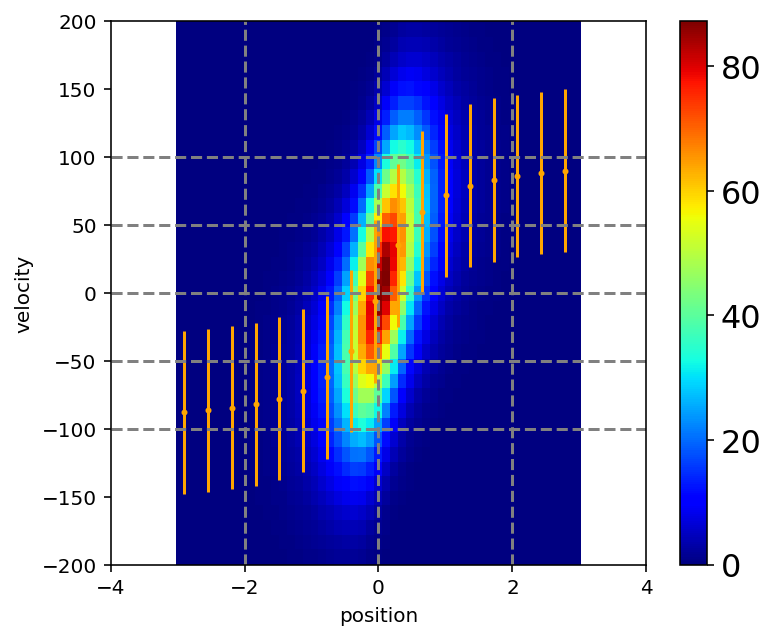

In [10]:
#%matplotlib
%matplotlib inline

ncol=1

fig,ax = plt.subplots(1,1,figsize=(6,5))
plt.rc('font',size=16)

POS, VEL = np.meshgrid(spaceGrid, vGrid)  # VEL, POS = np.meshgrid(grid_velocity, GaussFit.grid_pos)
img0=ax.pcolormesh(POS, VEL, GaussFit.spec2D.array.T, cmap='jet')          # img0 = ax.pcolormesh(POS, VEL, data, cmap='Greys')

#### gaussfit image peak identification summary (yellow)
ax.errorbar(spaceGrid[1::3], fitted_peakVelocity[1::3], yerr = fitted_velocity_error[:,1::3], color='orange', marker='o', markersize=2, ls='none', label='gauss1D fit on 2D spec')

ax.axhline(0., color='gray',ls='--')
ax.axhline(100., color='gray',ls='--')
ax.axhline(-100., color='gray',ls='--')
ax.axvline(0., color='gray',ls='--')
ax.axvline(2., color='gray',ls='--')
ax.axvline(-2., color='gray',ls='--')
ax.axhline(50., color='gray',ls='--')
ax.axhline(-50., color='gray',ls='--')

fig.colorbar(img0, ax=ax)
ax.set_xlim((-4, 4))
ax.set_ylim((-200., 200.))

ax.set_xlabel('position')
ax.set_ylabel('velocity')

# Plot spectrum (lambda unit)

In [11]:
spec2D = dataInfo['spec'][0]

#GaussFit = GaussFit_signle(spec2D, lambda0)
GaussFit = GaussFit_signle(spec2D=spec[0], lambda0=lambda0, thresholdSNR=5e-6)


fitted_peakLambda, fitted_amp, fitted_sigma = GaussFit.gaussFit_spec2D()
model = GaussFit.model_spec2D(fitted_peakLambda,fitted_amp,fitted_sigma)
data = GaussFit.spec2D.array

# get pixel edges
lambda_min = np.min(GaussFit.spec2D.lambdaGrid)  ; lambda_MAX = np.max(GaussFit.spec2D.lambdaGrid)
x_min = np.min(GaussFit.spec2D.spaceGrid)        ; x_MAX = np.max(GaussFit.spec2D.spaceGrid)

time cost in gaussFit_spec2D: 0.057041168212890625 (secs)


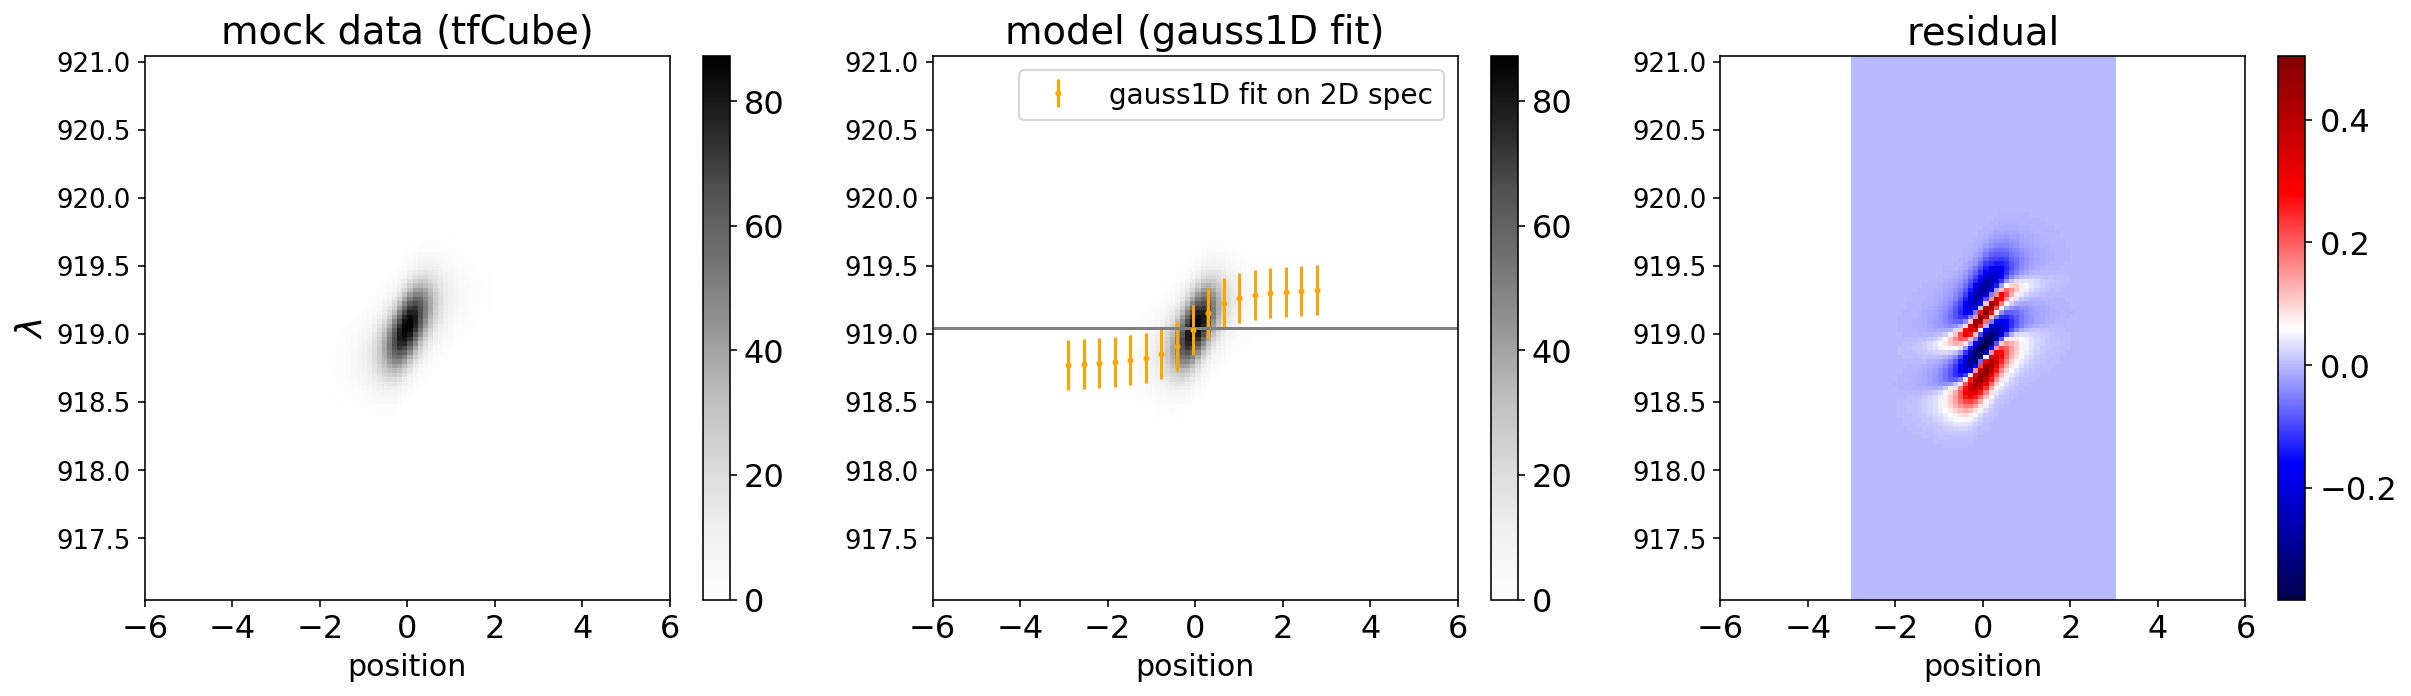

In [12]:
#%matplotlib
%matplotlib inline

ncol=3

fig,ax = plt.subplots(1,ncol,figsize=(20,5))
plt.rc('font',size=16)

img0=ax[0].imshow(data.T , extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
img1=ax[1].imshow(model.T, extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
#img2=ax[2].imshow((data.T-model.T)/data.T, extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap=plt.cm.seismic, origin="lower")
img2=ax[2].imshow((data.T-model.T), extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap=plt.cm.seismic, origin="lower")

fig.colorbar(img2, ax=ax[2])
fig.colorbar(img0, ax=ax[0])
fig.colorbar(img1, ax=ax[1])

#### gaussfit image peak identification summary (yellow)
ax[1].errorbar(GaussFit.spec2D.spaceGrid[1::3], fitted_peakLambda[1::3], fitted_sigma[1::3] ,color='orange', marker='o', markersize=2,ls='none',label='gauss1D fit on 2D spec')

ax[1].axhline(lambda_cen, color='gray')

for j in range(ncol):
    #ax[j].set_ylim(vcen-1.5,vcen+1.5)
    #ax[j].set_xlim(-3.5,3.5)
    ax[j].set_xlabel('position', fontsize=15)
    ax[j].tick_params(axis='x', labelsize=16)
    ax[j].tick_params(axis='y', labelsize=13)
    ax[j].set_xticks([-6, -4, -2, 0, 2, 4, 6])

ax[0].set_ylabel(r'$\lambda$', fontsize=18)    
ax[0].set_title('mock data (tfCube)')
ax[1].set_title('model (gauss1D fit)')
ax[2].set_title('residual')

#ax[1].legend(loc=(2.3,0.75),prop={'size':16})
ax[1].legend(loc="best",prop={'size':14})

plt.show()

# Check gaussian fit in 1D

peak lambda = 918.94 nm
peak amp = 30.39 photons
1 sigma = 0.18 nm


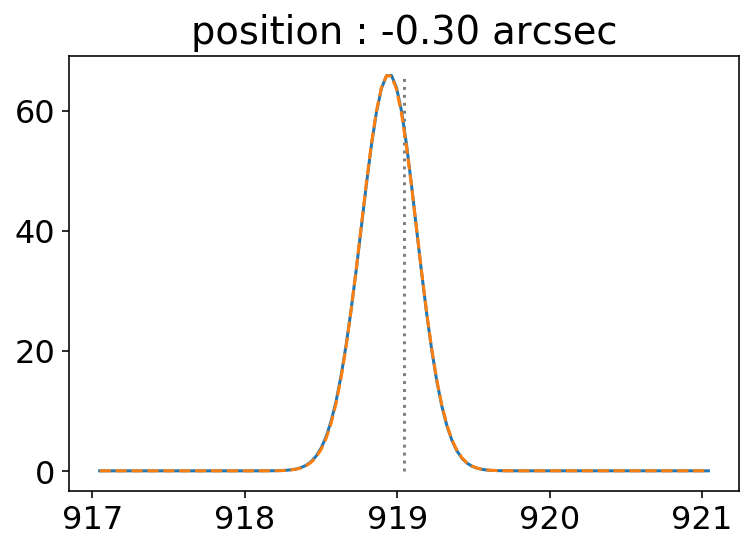

In [13]:
j=23

spec2D = dataInfo['spec'][0]

GaussFit = GaussFit_signle(spec2D, dataInfo['lambda0'], thresholdSNR=5e-6)

best_vals = GaussFit._fitGauss_per_bin(j, GaussFit.gaussian_single)
plt.plot(GaussFit.spec2D.lambdaGrid, GaussFit.spec2D.array[j])
plt.plot(GaussFit.spec2D.lambdaGrid, GaussFit.gaussian_single(GaussFit.spec2D.lambdaGrid, *best_vals), ls="--")
plt.vlines(x=lambda_cen, ymin=0, ymax=max(GaussFit.spec2D.array[j]), color='gray', ls=':')

plt.title(f'position : {GaussFit.spec2D.spaceGrid[j]:.2f} arcsec')
print(f'peak lambda = {best_vals[0]:.2f} nm')
print(f'peak amp = {best_vals[1]:.2f} photons')
print(f'1 sigma = {best_vals[2]:.2f} nm')